# Description

In this exercise, we will visualize the UK Constituency data we used in the previous week. continue the analysis of UK Political Data. 


# Clone a data repository

As we will use the data for several weeks, I decided to create a separate repository for the data. We can clone the reposiotory to Colab working directory to start working on the data.

For this week, I added parliamentary constituency shape file, downloaded from here:

https://geoportal.statistics.gov.uk/datasets/5ce27b980ffb43c39b012c2ebeab92c0_2


In [1]:
!git clone  https://github.com/University-of-Essex-Dept-of-Government/GV918-UK-politics-data

Cloning into 'GV918-UK-politics-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


# Load packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Rerun the code from the last week

In [3]:

df_elec = pd.read_excel("/content/GV918-UK-politics-data/Data/general-election-results-2019.xlsx", sheet_name = 'voting-summary')

df_brexit = pd.read_csv("/content/GV918-UK-politics-data/Data/brexit-vote.csv")

df_brexit.rename({'PCON11CD':'ons_id'}, axis = 1, inplace=True)

"""## Select columns"""

df_brexit.rename({'Figure to use':'leave_pct'}, axis = 1, inplace=True)

df_brexit_sub = df_brexit[['ons_id', 'leave_pct']]

df_elec['con_pct'] = df_elec['con'] / df_elec['valid_votes']
df_elec['lab_pct'] = df_elec['lab'] / df_elec['valid_votes']

df_elec.head()

"""# Unemployment data"""
# use "left" merge

df_merge = df_elec.merge(df_brexit_sub, how='left', on = "ons_id")
df_unemp = pd.read_excel('/content/GV918-UK-politics-data/Data/Unemployment.xlsx', sheet_name = "Data")
df_unemp_sub = df_unemp[df_unemp['DateOfDataset'] == '2019-11-01'][['ONSConstID', 'UnempConstRate']]
df_merge = df_merge.merge(df_unemp_sub, left_on = 'ons_id', right_on = 'ONSConstID')

"""# Housing price dataset"""

df_housing = pd.read_excel("/content/GV918-UK-politics-data/Data/House-prices.xlsx", 
                           sheet_name="Constituency data table")

df_housing['ConstPercentChangeOneYr'] = pd.to_numeric(df_housing['ConstPercentChangeOneYr'],
                                                                 errors='coerce')
df_housing_sub = df_housing[['ONSConstID', 'ConstPercentChangeOneYr']][df_housing['DateOfDataset'] == '2019-09-01']
df_merge = df_merge.merge(df_housing_sub, left_on="ons_id", right_on = "ONSConstID")

df_merge.head()

"""## Population dataset"""

df_pop = pd.read_excel("/content/GV918-UK-politics-data/Data/population-by-age.xlsx", 
                       sheet_name = 'Age by year data')
df_pop_sub = df_pop[df_pop['Age_year'] >= 65]
df_elderly = df_pop_sub[['PCON11CD', 'Age_percent']].groupby('PCON11CD').sum().reset_index()
df_merge = df_merge.merge(df_elderly, left_on = 'ons_id', right_on = 'PCON11CD')

df_merge.loc[:, ['con_pct', 'lab_pct','leave_pct', 'Age_percent', 'ConstPercentChangeOneYr', 'UnempConstRate']].corr()


,con_pct,lab_pct,leave_pct,Age_percent,ConstPercentChangeOneYr,UnempConstRate
con_pct,1.000000,-0.411415,0.595458,0.564467,-0.060931,-0.414482
lab_pct,-0.411415,1.000000,-0.150890,-0.593286,0.137952,0.568125
leave_pct,0.595458,-0.150890,1.000000,0.393101,0.167908,0.168809
Age_percent,0.564467,-0.593286,0.393101,1.000000,0.021177,-0.379418
ConstPercentChangeOneYr,-0.060931,0.137952,0.167908,0.021177,1.000000,0.189798
UnempConstRate,-0.414482,0.568125,0.168809,-0.379418,0.189798,1.000000


In [4]:
df_merge.shape

(650, 48)

# Basic visualisation

## Distribution conservative vote percentage, leave vote

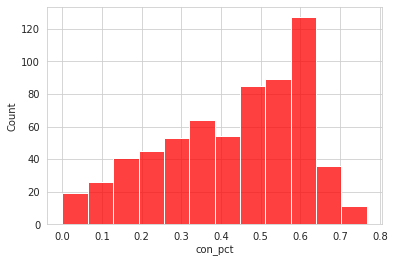

In [38]:
sns.histplot(x="con_pct", data=df_merge, color="r")

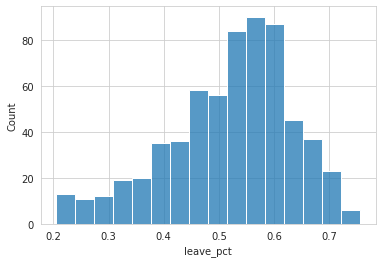

In [8]:
sns.histplot(x="leave_pct", data=df_merge)

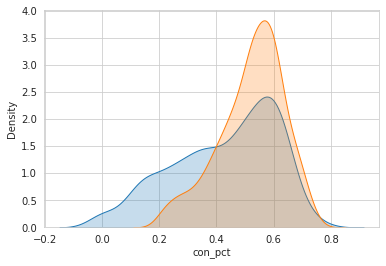

In [37]:
sns.kdeplot(x="con_pct", data=df_merge, fill=True)
sns.kdeplot(x="leave_pct", data=df_merge, fill=True)

## Scatter plot

### conservative vote against leave vote

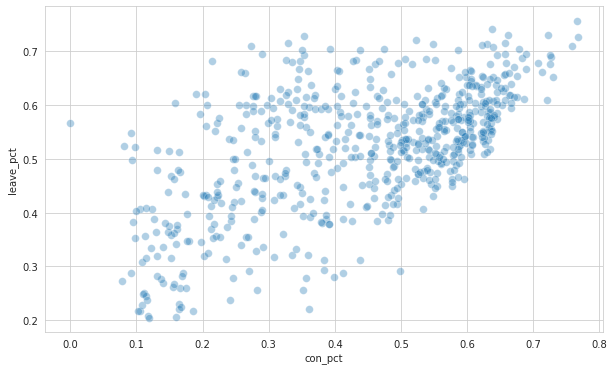

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="con_pct", y="leave_pct", data=df_merge, alpha=0.35, s=60)

### conservative vote against leave vote, by country

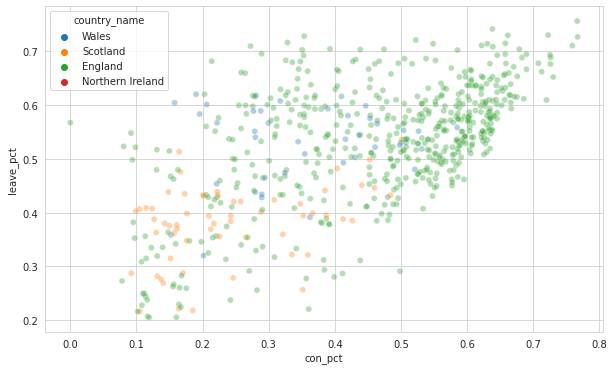

In [45]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="con_pct", y="leave_pct", data=df_merge, hue="country_name", alpha=0.35)

## Do similar with joint plot

### Subset the data with england, and plot by region

### Use only London

## Box and Violin

### Unemployment across regions

### Leave vote across regions

## Pairplot

# Heatmap

Heatmat is one of the good tool for telling a story with data. 

For example, the figure, included in the slides used by the scientific advisor at the press conference for second lockdown announcement, conveys a rich information about the general tendency across the regions and age groups (see page 5).

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/931774/Slides_to_accompany_coronavirus_press_conference-_CMO-_31_October_2020.pdf

We will create a simple heatmap from the correlation table:

In [ ]:
tab_cor = df_merge.loc[:, ['con_pct', 'lab_pct','leave_pct', 'Age_percent', 'ConstPercentChangeOneYr', 'UnempConstRate']].corr()
tab_cor

# Plotting the values on the map

Here, we will see how to create a figure using a map. Whether you can craete a map figure largely depends on the availability of shapfiles, which describes the shapes of polygons for the geographical boudaries. Once you find the file, it is not too complicated.

First, we install a package to work with shapefiles in pandas/matplotlib.

### Install geopandas

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd

### Unzip shapefile

In [ ]:
!unzip /content/GV918-UK-politics-data/Data/Westminster_Parliamentary_Constituencies__December_2017__Boundaries_UK-shp.zip \
 -d /content/const-shape

In [ ]:
!ls /content/const-shape

### Read the shapefile

In [ ]:
df_map = gpd.read_file('/content/const-shape/Westminster_Parliamentary_Constituencies__December_2017__Boundaries_UK.shp')

## Plot map

### Merge political dataset



### Two maps: UK and London Separately

### Plot Leave Percentage

### Plot leave percentage (UK and London, two maps)

### Final figure

### Categorical (winning parties)